In [1]:
import numpy as np
import pandas as pd 
import netCDF4
from netCDF4 import Dataset
import geopandas as gpd

import sklearn
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import nbimporter
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Conv1D, Conv2D,Dense, Dropout, Input, Concatenate, MaxPooling1D, BatchNormalization
import tensorflow.keras

from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Concatenate
from keras.callbacks import ModelCheckpoint
import h5py
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd 
import netCDF4
from netCDF4 import Dataset
import geopandas as gpd
import sklearn
import warnings
warnings.filterwarnings("ignore")
import nbimporter
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers import Conv1D,Dense, Dropout, Input
import tensorflow.keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Concatenate
from keras.callbacks import ModelCheckpoint
import h5py
from keras.models import load_model
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
import json
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
import matplotlib.pyplot as plt


cultures = {}
with open('lexique_cultures.json') as file:
    cultures = json.load(file)

2023-07-31 08:59:47.647037: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-31 08:59:48.280918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 08:59:54.366231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%run -i geoprocessing.py
rand_state=np.random.randint(50)

In [3]:
path_departments ='Geojson_files/contour-des-departements.geojson'
French_departments = gpd.read_file(path_departments)
regions_names,geometries,code_list=geojson_extract(French_departments,np.arange(len(French_departments)),'nom','geometry','code')
geojson_columns= {'Region Name': regions_names, 'Geometry':geometries,'code':code_list}
Regions=gpd.GeoDataFrame(geojson_columns)
regs_to_remove=['Paris','Haute-Corse','Corse-du-Sud']

Regions, reg_names, code_list = remove_regions(Regions,regs_to_remove)
reg_names = replace_substring(reg_names)

### Retrieving processed data 

In [4]:
nb_years_tot=23
data_matrix_load = np.loadtxt("data_matrix_departments.txt")

data_features=['u10', 'v10', 't2m', 'evabs', 'evatc', 'evavt','src', 'stl1', 'sp', 'e', 'tp', 'swvl1']
Nb_examples = len(Regions) * nb_years_tot
data_matrix_init= data_matrix_load.reshape(
    data_matrix_load.shape[0], data_matrix_load.shape[1] //  len(data_features), len(data_features))
data_matrix_init=data_matrix_init.reshape((Nb_examples,365,len(data_features)))

# Partie choix paramètres

In [252]:
# Choix de la culture :

nb_experiments=1

culture_num=150

year_choice=2015
# [2021,2022]

test_score=False
data_test_size=0.1

#This will give us a score for test_size  if True

# Mettre False rendra les évaluations déterministes i.e même données d'entraînement, même données de test (utiles pour test de score avec d'autres paramètres), 
# Mettre True rendra les évaluations non déterministes

random = True

# [True,False]


feature_choice=[0,2,10]
# feature_choice=[0,1,2,3,4,5,6,7,8,9,10,11]
# data_features=['u10', 'v10', 't2m', 'evabs', 'evatc', 'evavt','src', 'stl1', 'sp', 'e', 'tp', 'swvl1']


#Nombre d'itérations d'entraînement
nb_epochs=30
# [20 to 35]

#Départ de l'enregistrement de loss minimal trouvé
start_loss_checkpoint=12
# [8 to 15 ]


# Paramètres de l'optimiseur
optimizer_centering=False
#True,False
Verbose=1

# portions=np.arange(0.1,2.3,0.1)
portion=1.3

In [253]:
import json
cultures = {}
with open('lexique_cultures.json') as file:
    cultures = json.load(file)
culture_name=cultures[str(culture_num)]
culture_name


'Bl dur dhiver'

In [254]:
# 151,152

In [255]:
## Getting predictions and probabilities of loss of production

In [256]:

#Données production, année début / année fin
year_start=2000
year_finish=2020

#Ensemble des années représentées en données de production
years_data=np.arange(year_start,year_finish+1,1)
#Lecture du fichier excel de production d'une culture

    
rendement = pd.read_excel('Production data/cultures_2000_2020/rendement/culture_'+str(culture_num)+'Rendement'+'.xlsx')


#Removing column name
reg_rep=np.delete(np.asarray(rendement.columns),0)

x_max_region,x_min_region,std_xmax,std_xmin,val_olymp_region,olymp_abs,mean_regions=gen_std_prod(years_data,rendement,reg_rep)

reg_filt = find_indices(code_list, reg_rep)


  
portions_min=np.round(np.mean(x_min_region),2)
portions_max=np.round(np.mean(x_max_region),2)


# portions=np.arange(min(x_min_region)+std_xmin,max(x_min_region)-std_xmax)
# portions=np.arange(portions_min,portions_max,0.05)

In [257]:

year_data_start=2000
drop_out_rate=0.1
outlayer_neurons=128

loss_histories=[]

year_pick=int(year_choice-year_data_start)
pick_years=[year_pick]
for reg in range(1,len(reg_filt)):
    pick_years.append(year_pick+len(years_data)*reg)

tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    centered=optimizer_centering,
    use_ema=False,
    name="RMSprop",
)
f1=[]

# for portion in portions : 
#         print(portion)
if random == True:
    rand_state=np.random.randint(50)
#Construction et définition du réseau de neurones 
labels=gen_labels_portion_4(years_data,rendement,reg_rep,portion)
data_matrix=region_year_filter(reg_filt,years_data,nb_years_tot,data_matrix_init,24,feature_choice)

if year_pick<len(years_data):

    data_matrix=np.delete(data_matrix,pick_years,axis=0)
    labels=np.delete(labels,pick_years,axis=0)

nb_regions=len(Regions) 



model = Sequential([

      layers.Conv1D(365, 14, padding='same', activation='relu', input_shape=(365,len(feature_choice)),name='first_conv_layer'),
      layers.MaxPooling1D(pool_size=8),
      layers.Dropout(drop_out_rate),
      layers.Conv1D(128, 4, padding='same', activation='relu',name='second_conv_layer'),
      layers.MaxPooling1D(pool_size=6),
      layers.Dropout(drop_out_rate),
      layers.Conv1D(64, 2, padding='same', activation='relu',name='last_conv_layer'),
      layers.MaxPooling1D(pool_size=4),
      layers.Dropout(drop_out_rate),
      layers.Flatten(),
      layers.Dense(outlayer_neurons, activation='relu'),
      layers.Dense(2,activation='softmax')

])


#Compilation du modèle
model.compile(optimizer='RMSProp',loss='CosineSimilarity',metrics='binary_accuracy' )

x_train, x_test, y_train, y_test = train_test_split(data_matrix,to_categorical(labels), test_size=0.05,random_state=rand_state)

mc = ModelCheckpoint('Test_weights/'+str(culture_num)+'_best_model_'+str(portion*100)+'.h5', monitor='val_loss', mode='min', verbose=0,save_best_only=True,start_from_epoch=start_loss_checkpoint)

history=model.fit(x_train, y_train,
                    epochs=nb_epochs,
                    batch_size=4,verbose=Verbose,class_weight=weights(labels,'binary'),validation_split=0.25,callbacks=[mc])


#         saved_model = load_model('Test_weights/'+ str(culture_num)+'_best_model_'+str(portion*100)+'.h5')


Epoch 1/30
129/129 [==============================] - 3s 20ms/step - loss: -0.7057 - binary_accuracy: 0.6940 - val_loss: -0.7103 - val_binary_accuracy: 0.9298
Epoch 2/30
129/129 [==============================] - 2s 19ms/step - loss: -0.7096 - binary_accuracy: 0.5575 - val_loss: -0.7141 - val_binary_accuracy: 0.9298
Epoch 3/30
129/129 [==============================] - 2s 18ms/step - loss: -0.7157 - binary_accuracy: 0.5029 - val_loss: -0.6788 - val_binary_accuracy: 0.0702
Epoch 4/30
129/129 [==============================] - 2s 19ms/step - loss: -0.7274 - binary_accuracy: 0.4308 - val_loss: -0.9186 - val_binary_accuracy: 0.9298
Epoch 5/30
129/129 [==============================] - 2s 18ms/step - loss: -0.7023 - binary_accuracy: 0.5712 - val_loss: -0.6964 - val_binary_accuracy: 0.0702
Epoch 6/30
129/129 [==============================] - 2s 19ms/step - loss: -0.7237 - binary_accuracy: 0.5653 - val_loss: -0.6900 - val_binary_accuracy: 0.0702
Epoch 7/30
129/129 [==========================

In [258]:
print(x_test[0].shape)

(365, 3)


In [259]:
print(heatmap)

[[0.         0.         0.25439683 1.         0.         0.1500926
  0.        ]]


(1, 365, 365)
Heatmap Shape: (1, 365)


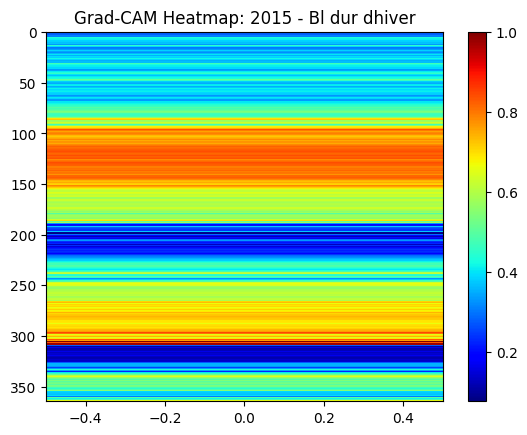

In [269]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load your pre-trained CNN model
model = load_model('Test_weights/'+ str(culture_num)+'_best_model_'+str(portion*100)+'.h5')
# Define the function to compute Grad-CAM
def grad_cam(model, input_data, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input_data)
        
        conv_outputs, predictions = grad_model(input_data)
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    print(grads.shape)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

example=0


# Prepare your test data and convert it to the required format
test_data = x_test[example] # Replace with your actual test data

# Reshape the test data to match the model's input shape (if necessary)
test_data = np.expand_dims(test_data, axis=0)  # Uncomment if the model expects a single example
test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)  # Convert to TensorFlow tensor

# Compute Grad-CAM for the last convolutional layer
# layer_name = 'last_conv_layer'  # Replace with the name of the last convolutional layer
layer_name = 'first_conv_layer'  # Replace with the name of the last convolutional laye
heatmap = grad_cam(model, test_data, layer_name)

# Print the heatmap shape
print("Heatmap Shape:", heatmap.shape)

# Now you can visualize or analyze the heatmap as needed.
# You may plot it, overlay it on the original input data, etc.
# For example, to visualize the heatmap for the first example in the test data:
import matplotlib.pyplot as plt

plt.imshow(heatmap.T, interpolation ='none', aspect = 'auto',cmap='jet')
plt.title("Grad-CAM Heatmap: "+str(year_choice)+ ' - '+str(culture_name) )
plt.colorbar()
plt.show()

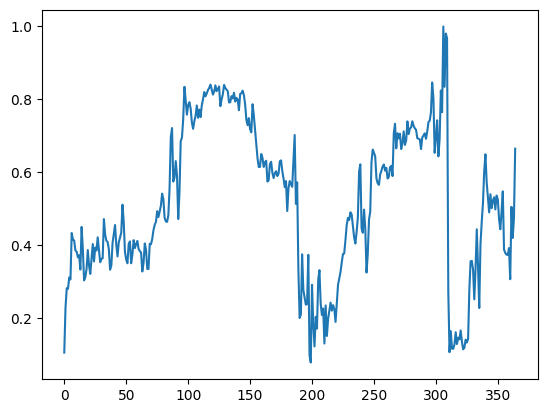

In [270]:
plt.plot(np.arange(len(heatmap.T)),heatmap.T)
plt.show()

In [10]:
## Getting predictions and probabilities of loss of production

In [1616]:
year_choice=2018
years_tot=np.arange(2000,2023,1)

data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,feature_choice)
year_pick=int(year_choice-year_data_start)


pick_years=[year_pick]
for reg in range(1,len(reg_filt)):
    pick_years.append(year_pick+nb_years_tot*reg)

test_year_data=data_matrix2[pick_years]

test_year_data.shape

(87, 365, 4)

In [1617]:
# #Génération des prédictions
prob_csv=[]
for portion in portions : 
        
        saved_model = load_model('Test_weights/'+str(culture_num)+'_best_model_'+str(portion*100)+'.h5')
        
        predictions=np.round(np.asarray(saved_model.predict(test_year_data))[:,1],2)
        prob_csv.append(predictions)

Columns=np.asarray(reg_rep)
prob_csv=pd.DataFrame(prob_csv,columns=Columns,index=portions)


3/3 [==============================] - 0s 13ms/step


23 59
Prédiction de la production la plus probable: 95.81%


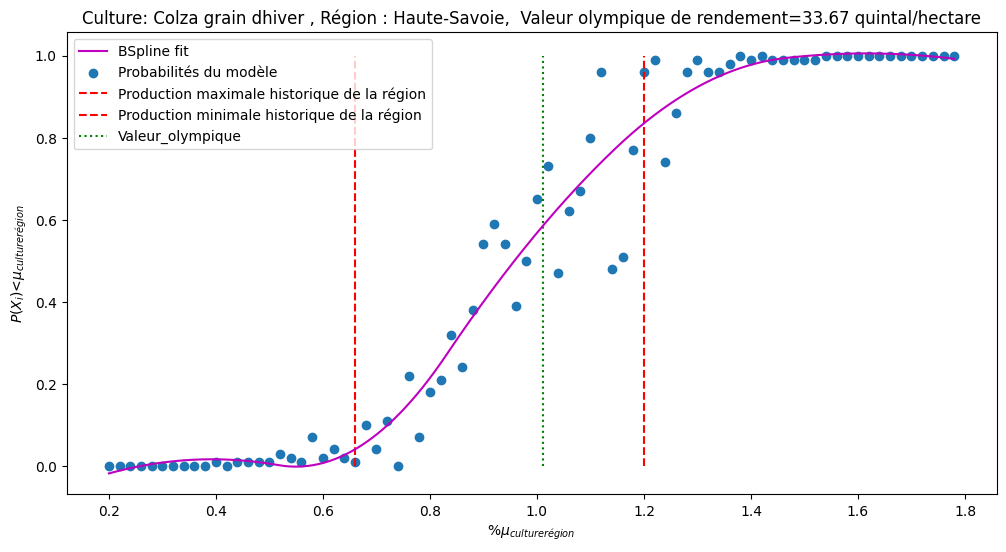

In [1624]:
import scipy.interpolate as interpolate
from scipy.interpolate import BSpline, splrep, splev


reg_filt_names=np.asarray(reg_names)[np.asarray(reg_filt).astype(int)]

N=20000
# 
choice=35
prob_region=np.asarray(prob_csv).T[choice] 

prob_region_cut,portions_cut=cut_prob2(prob_region,portions,x_min_region[choice],x_max_region[choice])

items_remove,smooth_curve=remove_outliers(prob_region_cut,portions_cut)

portions_out=np.delete(portions_cut,items_remove)
prob_region_out=np.delete(prob_region_cut,items_remove)

t, c, k = interpolate.splrep(portions, prob_region, s=0, k=4)


spline = interpolate.BSpline(t, c, k, extrapolate=False)

xmin, xmax =portions.min(), portions.max()
# xmin, xmax = portions_cut.min(), portions_cut.max()

xx = np.linspace(xmin, xmax, N)

n_interior_knots = 4
qs = np.linspace(0, 1, n_interior_knots+2)[1:-1]
knots = np.quantile(xx, qs)
tck = splrep(xx, spline(xx), t=knots, k=2)


ys_smooth = splev(xx, tck)

pred_likely=np.round(np.mean(xx[np.where(np.round(ys_smooth,2)==0.5)[0]])*100,2)

print('Prédiction de la production la plus probable: '+str(pred_likely)+'%')

# Display
plt.figure(figsize=(12, 6))
# plt.plot(xx, ys, '.c')
plt.plot(xx, ys_smooth, '-m',label='BSpline fit')
plt.scatter(portions,prob_region,label='Probabilités du modèle')

pred_olymp=np.where(ys_smooth==val_olymp_region[choice]*0.7)[0]

plt.ylabel(r'$P(X_{i})$<$\mu_{culture région}$')
plt.xlabel(r'$\%\mu_{culture région}$')
plt.title('Culture: '+str(culture_name)+' , Région : '+  str(reg_filt_names[choice])+',  Valeur olympique de rendement='+str(np.round(olymp_abs[choice],2))+' quintal/hectare')

plt.vlines(x_max_region[choice],0,1,label='Production maximale historique de la région',colors='r',linestyles='dashed')
plt.vlines(x_min_region[choice],0,1,label='Production minimale historique de la région',colors='r',linestyles='dashed')
plt.vlines(val_olymp_region[choice],0,1,label='Valeur_olympique',colors='g',linestyles='dotted')

plt.legend()
plt.show()
# plt.plot(xx,spline(xx))

In [1619]:
prod_france_year_fit=[]
prod_france_year_model=[]
N=10000
for choice in range(len(np.asarray(prob_csv).T)):
    
    most_prob=[] 

    #####

    prob_region=np.asarray(prob_csv).T[choice] 

    items_remove,smooth_curve= remove_outliers(prob_region,portions)
    smooth_curve= remove_outliers2(prob_region,portions)
    
    ext_remove=[]
    ext_remove.append(np.where(np.round(prob_region,4)==0)[0])
    # ext_remove.append(np.where(np.round(prob_region,1)==0.5)[0])
    ext_remove.append(np.where(np.round(prob_region,4)==1)[0])
    ext_remove=np.hstack(ext_remove)
    prob_region2=np.delete(prob_region,ext_remove)
    portions2=np.delete(portions,ext_remove)

    t, c, k = interpolate.splrep(portions, prob_region, s=0, k=4)
    # t, c, k = interpolate.splrep(portions, smooth_curve, s=0, k=4)
    # t, c, k = interpolate.splrep(portions2, prob_region2, s=0, k=4)

    spline = interpolate.BSpline(t, c, k, extrapolate=False)
        
    xmin, xmax =portions.min(), portions.max()
    # xmin, xmax =portions2.min() ,portions2.max()

    xx = np.linspace(xmin, xmax, N)

    n_interior_knots = 5
    
    qs = np.linspace(0, 1, n_interior_knots+2)[1:-1]
    knots = np.quantile(xx, qs)
    tck = splrep(xx, spline(xx), t=knots, k=2)
    ys_smooth = splev(xx, tck)
  
    prediction_rendement=np.nanmean(xx[np.where(np.round(ys_smooth,1)==0.5)[0]])*mean_regions[choice]
    prediction_rendement_model=np.mean(xx[np.where(np.round(spline(xx),4)==0.5)[0]])*mean_regions[choice]

    
    prod_france_year_fit.append(prediction_rendement)
    prod_france_year_model.append(prediction_rendement_model)
    
print('Prédiction smooth_Bspline du rendement moyen :', np.round(np.nanmean(prod_france_year_fit),1), 'quintals/h')
print('Prédiction Bspline du rendement moyen:', np.round(np.nanmean(prod_france_year_model),1), 'quintals/h')


Prédiction smooth_Bspline du rendement moyen : 29.2 quintals/h
Prédiction Bspline du rendement moyen: 28.8 quintals/h


In [1659]:
mean_rms,std_rms,min_rms,max_rms,rms,rms_noabs=rms_prod_model(prod_france_year_fit,rendement,year_choice)

# print(culture_name)
print('Delta moyen absolu prédiction modèle/réalité : ', mean_rms)
print('Delta écart type absolu entre prédiction modèle/réalité : ',std_rms)
print('Delta minimum absolu entre prédiction modèle/réalité : ',min_rms)
print('Delta max absolu entre prédiction modèle/réalité : ',max_rms)

Delta moyen absolu prédiction modèle/réalité :  2.3004339690126643
Delta écart type absolu entre prédiction modèle/réalité :  1.8656617139587368
Delta minimum absolu entre prédiction modèle/réalité :  0.00015464403583820285
Delta max absolu entre prédiction modèle/réalité :  7.330271427142719


Text(0, 0.5, 'Occurences')

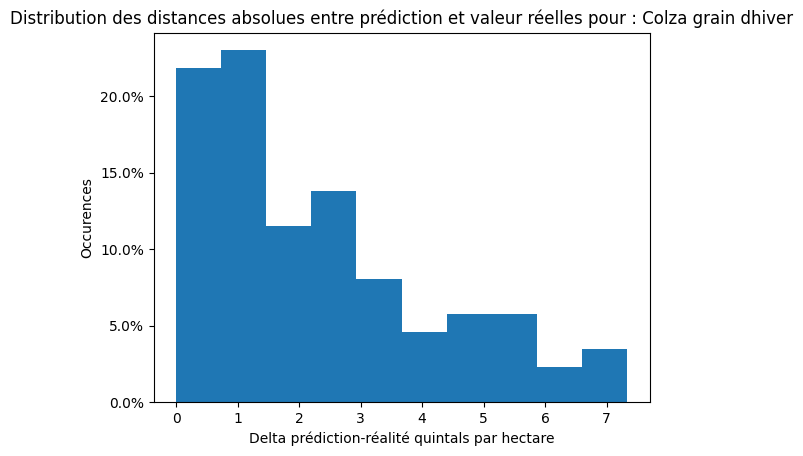

In [1660]:
from matplotlib.ticker import PercentFormatter

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.hist(rms, weights=np.ones(len(rms)) / len(rms))
plt.title('Distribution des distances absolues entre prédiction et valeur réelles pour : '+str(culture_name))
plt.xlabel('Delta prédiction-réalité quintals par hectare')
plt.ylabel('Occurences')

<AxesSubplot:ylabel='Density'>

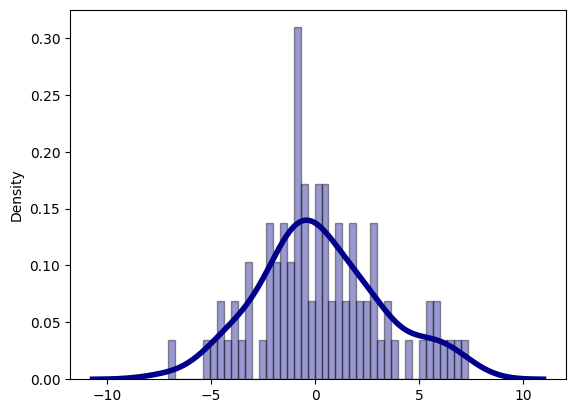

In [1664]:
import seaborn as sns

sns.distplot(rms_noabs,  hist=True, kde=True, 
             bins=int(len(rms)/2), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})


In [1666]:

score70,score80=accuracy_prod_assur(prod_france_year_fit,rendement,year_choice)

print(score70,score80)

0.011494252873563218 0.09195402298850575


In [1626]:
# prod_france_year_model
prod_france_year_fit

[30.4069049762119,
 37.46163568737824,
 25.952849451611822,
 17.883730944523016,
 34.51540874087408,
 17.232363807809346,
 25.04670486096228,
 32.84233209511426,
 25.79759452135689,
 26.626047604760462,
 34.90232766133756,
 20.222038160958945,
 33.41776901499672,
 28.113208273208265,
 29.316361969530274,
 26.80537237057038,
 27.777914219993416,
 29.705763909724297,
 31.88054112077874,
 28.231159425466345,
 24.85903490349034,
 29.772307611713543,
 23.530667590568573,
 32.61327575614703,
 35.22345544078215,
 36.267214149986415,
 31.949894860914657,
 20.886930435900727,
 26.81740960762742,
 23.57060887041084,
 32.58225555888921,
 28.023082212983198,
 21.543734087694475,
 27.25558334881106,
 30.25620617299824,
 32.234912348377684,
 28.617997990275207,
 19.839995751956145,
 26.389269403130783,
 18.817407626476925,
 31.008205563413476,
 27.188015111034904,
 28.803084165559397,
 30.521248791545812,
 31.6608463227275,
 25.72952295229522,
 29.30274634606317,
 23.908494658989703,
 27.14772434386

In [1608]:

steps_olymp=np.arange(0.4,1,0.1)

val_probs=[]
for step in steps_olymp:
    idx_pred_olymp=np.where(np.round(xx,2)==np.round(val_olymp_region[choice]*step,2))[0]
    val_probs.append(np.round(np.mean(ys_smooth[idx_pred_olymp])*100,2))

val_probs

[0.77, 3.83, 6.39, 8.27, 18.84, 45.45]